# Boxplot of top five up- and downregulated genes

In [1]:
suppressMessages({library(ggpubr)
                  library(tidyverse)
                  library(data.table)})

In [2]:
save_ggplots <- function(p, fn, w=7, h=7){
    for(ext in c('.svg', '.png', '.pdf')){
        ggsave(p, filename=paste0(fn, ext), width=w, height=h)
    }
}


add_symnum <- function(res){
    symnum.args <- list(cutpoints = c(0, 0.0001, 0.001, 0.01, 0.05,  1),
                        symbols = c("****", "***", "**", "*",  "ns"))
    symnum.args$x <- res$adj.P.Val
    pvalue.signif <- do.call(stats::symnum, symnum.args) %>%
        as.character()
    pvalue.format <- format.pval(res$adj.P.Val, digits = 2)
    res <- res %>%
        dplyr::ungroup() %>%
        mutate(FDR = pvalue.format, p.signif = pvalue.signif)
    return(res)
}


## Select most significant DEGs, up- and downregulated

In [3]:
genes = fread('../../metrics_summary/_m/female_specific_DE_4features.txt') %>%
    filter(Type == 'gene') %>% add_symnum()
up_genes = genes %>% filter(t > 0) %>% mutate('Direction'='Upregulated') %>% head(5)
down_genes = genes %>% filter(t < 0) %>% mutate('Direction'='Downregulated') %>% head(5)
sig_genes = bind_rows(up_genes, down_genes) %>% mutate_at(vars(Direction), as.factor)

for(xx in seq_along(sig_genes$Symbol)){
    sig_genes$New_ID[xx] <- ifelse(sig_genes$Symbol[xx] == '', 
                                   as.character(sig_genes$ensemblID[xx]), 
                                   as.character(sig_genes$Symbol[xx]))
}
sig_genes

Feature,gencodeID,Symbol,ensemblID,Chrom,logFC,t,adj.P.Val,Male_Pval,Male_FDR,Type,FDR,p.signif,Direction,New_ID
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<fct>,<chr>
ENSG00000070915.9,ENSG00000070915.9,SLC12A3,ENSG00000070915,chr16,0.8484950,4.756160,0.001680123,0.34966615,0.3783274,gene,0.0017,**,Upregulated,SLC12A3
ENSG00000263006.6,ENSG00000263006.6,ROCK1P1,ENSG00000263006,chr18,0.5377325,4.498877,0.003265003,0.14234505,0.1873658,gene,0.0033,**,Upregulated,ROCK1P1
ENSG00000141750.6,ENSG00000141750.6,STAC2,ENSG00000141750,chr17,0.2642853,4.392359,0.004230900,0.43604989,0.4471091,gene,0.0042,**,Upregulated,STAC2
ENSG00000167703.14,ENSG00000167703.14,SLC43A2,ENSG00000167703,chr17,0.2667939,4.156480,0.007618940,0.21271713,0.2556329,gene,0.0076,**,Upregulated,SLC43A2
ENSG00000224273.2,ENSG00000224273.2,,ENSG00000224273,chr7,0.6257959,4.116018,0.008205477,0.29731256,0.3299586,gene,0.0082,**,Upregulated,ENSG00000224273
ENSG00000111181.12,ENSG00000111181.12,SLC6A12,ENSG00000111181,chr12,-0.4568383,-4.917349,0.001106169,0.08689851,0.1333155,gene,0.0011,**,Downregulated,SLC6A12
ENSG00000249669.8,ENSG00000249669.8,CARMN,ENSG00000249669,chr5,-0.5361515,-4.285193,0.005433342,0.06147502,0.1005632,gene,0.0054,**,Downregulated,CARMN
ENSG00000169031.18,ENSG00000169031.18,COL4A3,ENSG00000169031,chr2,-0.3208143,-4.068080,0.009079960,0.16095601,0.2070480,gene,0.0091,**,Downregulated,COL4A3
ENSG00000228878.7,ENSG00000228878.7,SEPT7-AS1,ENSG00000228878,chr7,-0.2683886,-4.053475,0.009354322,0.11508809,0.1613723,gene,0.0094,**,Downregulated,SEPT7-AS1


## Load phenotypes

In [4]:
pheno_file = '/ceph/projects/v3_phase3_paper/inputs/phenotypes/_m/caudate_phenotypes.csv'
pheno = fread(pheno_file) %>% column_to_rownames(var='V1') %>% 
    mutate_if(is.character, as.factor)
levels(pheno$Sex) <- c("Female", "Male")
levels(pheno$Dx) <- c("BD", "CTL", "SZ")
pheno %>% head(2)

,BrNum,RNum,Region,RIN,Age,Sex,Race,Dx
,<fct>,<fct>,<fct>,<dbl>,<dbl>,<fct>,<fct>,<fct>
R12864,Br1303,R12864,Caudate,9.6,42.98,Female,AA,SZ
R12865,Br1320,R12865,Caudate,9.5,53.12,Male,AA,SZ


## Load residualized expression

In [5]:
res_file = '../../../../../interaction_model/caudate/_m/genes/residualized_expression.tsv'
resdf0 = fread(res_file) %>% 
    filter(V1 %in% sig_genes$gencodeID) %>% 
    column_to_rownames(var="V1") %>% t %>% 
    as.data.frame %>% rownames_to_column("RNum")
resdf0[1:2, 1:5]

Warning message in fread(res_file):
"Detected 393 column names but the data has 394 columns (i.e. invalid file). Added 1 extra default column name for the first column which is guessed to be row names or an index. Use setnames() afterwards if this guess is not correct, or fix the file write command that created the file to create a valid file."


,RNum,ENSG00000183298.5,ENSG00000169031.18,ENSG00000249669.8,ENSG00000228878.7
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,R12864,0.70060990,-0.25776501,0.2725810,-1.9740023
2,R12865,0.08171483,-0.06237113,0.6926096,-0.5952965


### Merge and melt dataframe

In [6]:
df <- inner_join(pheno, resdf0, by="RNum") %>%
    select(c('RNum', 'Sex', 'Dx', starts_with('ENSG'))) %>% 
    pivot_longer(-c(RNum, Sex, Dx), names_to='gencodeID', values_to="Res") %>% 
    inner_join(sig_genes, by='gencodeID') %>% 
    mutate_at(vars("New_ID", "Symbol", "gencodeID"), as.factor)
df$New_ID = with(df, reorder(New_ID, adj.P.Val, median))
df$Dx <- fct_drop(df$Dx)
dim(df)
df[1:2, 1:10]

[1] 3930   19

RNum,Sex,Dx,gencodeID,Res,Feature,Symbol,ensemblID,Chrom,logFC
<chr>,<fct>,<fct>,<fct>,<dbl>,<chr>,<fct>,<chr>,<chr>,<dbl>
R12864,Female,SZ,ENSG00000183298.5,0.7006099,ENSG00000183298.5,RPSAP19,ENSG00000183298,chr1,-0.7055891
R12864,Female,SZ,ENSG00000169031.18,-0.2577650,ENSG00000169031.18,COL4A3,ENSG00000169031,chr2,-0.3208143


### Initial ggplot with ggpubr

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


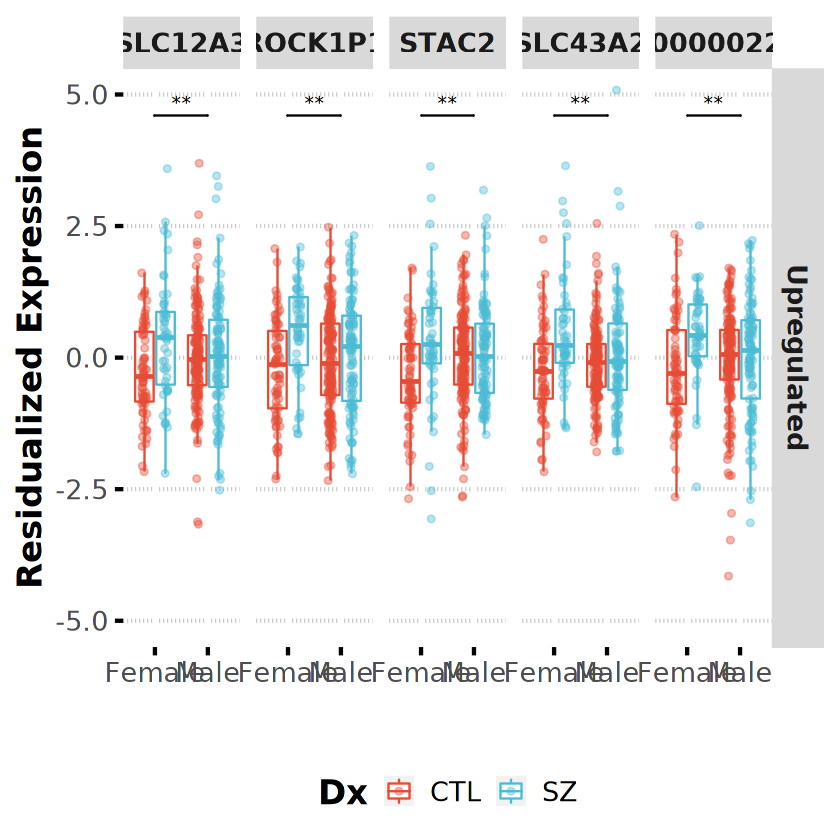

In [7]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=4.6) %>% 
    filter(Direction == 'Upregulated') %>%
    mutate_if(is.character, as.factor)

bxp_up <- df %>% filter(Direction == "Upregulated") %>%
    ggboxplot(x="Sex", y="Res", color="Dx", facet.by=c("Direction", "New_ID"), 
              xlab="", add="jitter", palette="npg", ylim=c(-5,5), 
              panel.labs.font=list(face='bold'), legend="bottom", 
              ylab='Residualized Expression', add.params=list(alpha=0.4),
              ggtheme=theme_pubclean(base_size=20))+
    geom_signif(data=tmp, tip_length = 0, manual=TRUE,
                aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos)) +
    font("xy.title", face="bold") + font("legend.title", face="bold")
bxp_up

Warning message:
"Ignoring unknown aesthetics: xmin, xmax, annotations, y_position"


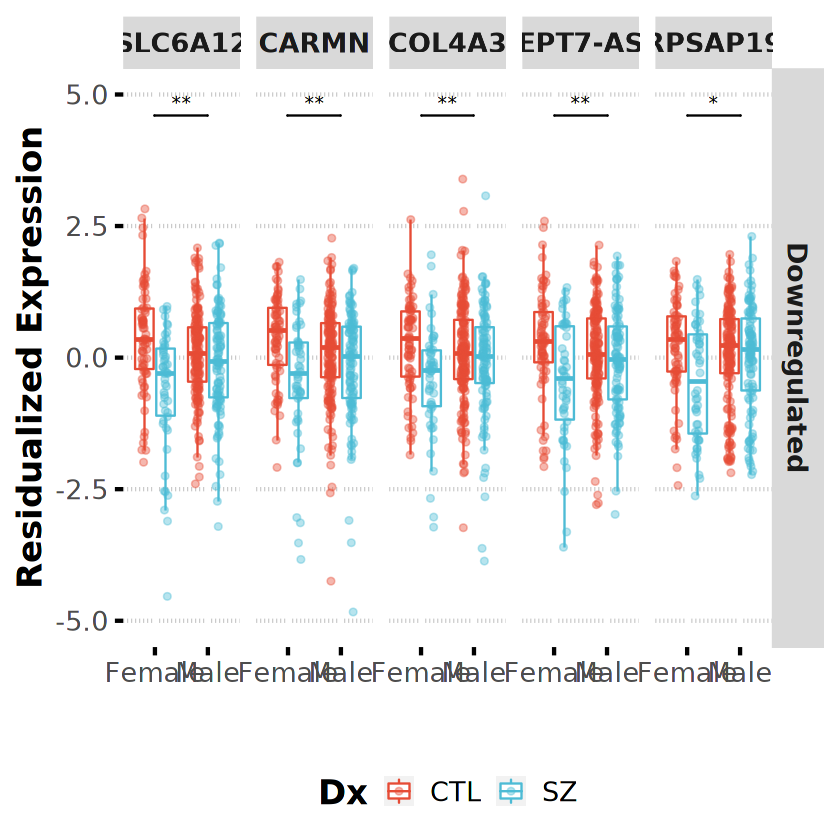

In [8]:
tmp = sig_genes %>% 
    mutate(group1='Female', group2='Male', y_pos=4.6) %>% 
    filter(Direction == 'Downregulated') %>%
    mutate_if(is.character, as.factor)

bxp_down <- df %>% filter(Direction=="Downregulated") %>%
    ggboxplot(x="Sex", y="Res", color="Dx", facet.by=c("Direction", "New_ID"), 
              xlab='', palette="npg", add='jitter', ylim=c(-5, 5),
              panel.labs.font=list(face='bold'), legend="bottom", 
              ylab='Residualized Expression', add.params=list(alpha=0.4), 
              ggtheme=theme_pubclean(base_size=20)) +
    geom_signif(data=tmp, tip_length = 0, manual=TRUE,
                aes(xmin=group1, xmax=group2, annotations=p.signif, y_position = y_pos)) + 
    font("xy.title", face="bold") + font("legend.title", face="bold")     
bxp_down

### Annotate figure

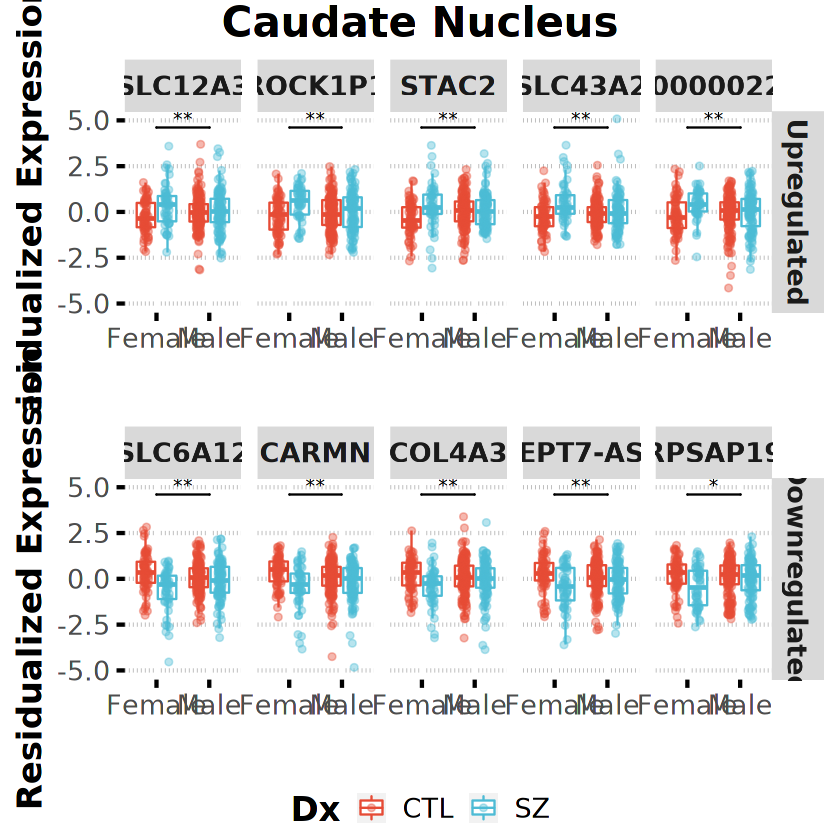

In [11]:
figure <- ggarrange(bxp_up, bxp_down, ncol = 1, nrow = 2, 
                    common.legend = TRUE, legend="bottom")
figure <- annotate_figure(figure, top=text_grob("Caudate Nucleus", size=25, face='bold'))
figure

In [12]:
save_ggplots(figure, 'femaleSpecific_SZ', 12, 10)

## Session Info

In [ ]:
Sys.time()
proc.time()
options(width = 120)
sessioninfo::session_info()